In [1]:
import numpy as np
import matplotlib.pylab as plt
import os
from astropy.io import fits
from scipy.spatial import Delaunay, cKDTree
from scipy.interpolate import LinearNDInterpolator
from numpy.lib.recfunctions import append_fields
import emcee
from multiprocessing import Pool
from astropy.io import fits
import time
import sys
import corner

In [2]:

#number = int(sys.argv[1])
#divisor = int(sys.argv[2])

#if os.path.isfile('result/result_%d.fits' %(number)):
#    print('file %d exists.. skipped' %(number))
#    sys.exit()



# Need to initialise the interpolation grid globally
data = fits.getdata('../data/Elbadry_200pc_binaries_v2_ruwe_a0_prior.fits')
data = data.view(np.recarray)
data = append_fields(data,"phot_g_mean_mag_error",np.divide(1.086,data.phot_g_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_g_mean_mag_error2",np.divide(1.086,data.phot_g_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_rp_mean_mag_error",np.divide(1.086,data.phot_rp_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_rp_mean_mag_error2",np.divide(1.086,data.phot_rp_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_bp_mean_mag_error",np.divide(1.086,data.phot_bp_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_bp_mean_mag_error2",np.divide(1.086,data.phot_bp_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"parallax_error",np.divide(1,data.parallax_over_error)*data.parallax,
                     usemask=False, asrecarray=True)
data = append_fields(data,"parallax_error2",np.divide(1,data.parallax_over_error2)* data.parallax2,
                     usemask=False, asrecarray=True)

# Add new fields:
array = np.zeros(len(data))
components = ["","2"]

quality_names = ['mean_acceptance_fraction']

percentiles = ["","_lower","_upper"]
field_names = ['lnprob','teff','logg','feh','mass','age','a0','logl']
array_list = []
name_list = []
for component in components:
    for quality_name in quality_names:
        array_list.append(array)
        name_list.append(quality_name + component)
    for field_name in field_names:
        for percentile in percentiles:
            array_list.append(array)
            name_list.append(field_name + percentile + component)
data = append_fields(data,name_list,array_list,usemask=False, asrecarray=True)
print(len(data), data.dtype)
# correct for the G magnitude systematic error

g_corr = np.copy(data.phot_g_mean_mag)
cut = (data.phot_g_mean_mag <= 6)
g_corr[cut] = data.phot_g_mean_mag[cut] + 0.0271 * ( 6 - data.phot_g_mean_mag[cut])
cut = (data.phot_g_mean_mag > 16)
g_corr[cut] = data.phot_g_mean_mag[cut] - 0.032
cut = (data.phot_g_mean_mag <= 16) & (data.phot_g_mean_mag > 6)
g_corr[cut] = data.phot_g_mean_mag[cut] - (0.0032 * (data.phot_g_mean_mag[cut]-6))
data.phot_g_mean_mag = g_corr

g_corr = np.copy(data.phot_g_mean_mag2)
cut = (data.phot_g_mean_mag2 <= 6)
g_corr[cut] = data.phot_g_mean_mag2[cut] + 0.0271 * ( 6 - data.phot_g_mean_mag2[cut])
cut = (data.phot_g_mean_mag2 > 16)
g_corr[cut] = data.phot_g_mean_mag2[cut] - 0.032
cut = (data.phot_g_mean_mag2 <= 16) & (data.phot_g_mean_mag2 > 6)
g_corr[cut] = data.phot_g_mean_mag2[cut] - (0.0032 * (data.phot_g_mean_mag2[cut]-6))
data.phot_g_mean_mag2 = g_corr
# correct for the underestimated internal parallax uncertainty
def external_uncertainty(internal_uncertainty):
    k = 1.08
    sigma_s = 0.043
    return(np.sqrt( k**2 * internal_uncertainty**2 + sigma_s**2))
data.parallax_error = external_uncertainty(data.parallax_error)
data.parallax_error2 = external_uncertainty(data.parallax_error2)

# correct for the zero parallax offset
data.parallax += 0.05
data.parallax2 += 0.05

# increase minimum photometric noise to 0.03
#data.phot_g_mean_mag_error[(data.phot_g_mean_mag_error<0.03)] = 0.03

55507 (numpy.record, [('source_id2', '>i8'), ('ra2', '>f8'), ('dec2', '>f8'), ('astrometric_chi2_al_2', '>f8'), ('astrometric_n_good_obs_al2', '>i8'), ('phot_g_mean_flux_over_error2', '>f8'), ('phot_rp_mean_flux_over_error2', '>f8'), ('phot_bp_mean_flux_over_error2', '>f8'), ('phot_bp_rp_excess_factor2', '>f8'), ('pmra2', '>f8'), ('pmra_error2', '>f8'), ('pmdec2', '>f8'), ('pmdec_error2', '>f8'), ('phot_g_mean_mag2', '>f8'), ('phot_bp_mean_mag2', '>f8'), ('phot_rp_mean_mag2', '>f8'), ('parallax2', '>f8'), ('parallax_over_error2', '>f8'), ('radial_velocity2', '>f8'), ('radial_velocity_error2', '>f8'), ('rv_nb_transits2', '>i8'), ('source_id', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('pmra', '>f8'), ('pmra_error', '>f8'), ('pmdec', '>f8'), ('pmdec_error', '>f8'), ('phot_g_mean_mag', '>f8'), ('phot_bp_mean_mag', '>f8'), ('phot_rp_mean_mag', '>f8'), ('parallax', '>f8'), ('parallax_over_error', '>f8'), ('astrometric_chi2_al', '>f8'), ('astrometric_n_good_obs_al', '>i8'), ('phot_g_mean_flux_o

In [21]:
def get_error(gmag,gmagerror,parallax,parallaxerror,rpmag,rpmagerror):
    '''
    creating absolute g magnitude and error and color and error from g, rp mag, parallax and respective errors
    via gaussian error sampling
    '''
    #propagate both errors
    abs_g = np.random.normal(gmag,gmagerror,1000) + 5 * np.log10(np.divide(np.random.normal(parallax,parallaxerror,1000),100))
    gd = np.mean(abs_g)
    ge = np.std(abs_g) 
    # BPRP error
    c = np.random.normal(gmag,gmagerror,1000) - np.random.normal(rpmag,rpmagerror,1000)
    cd = np.mean(c)
    ce = np.std(c)
    return(gd,ge,cd,ce)

# We have to define a log likelihood it measures how well the model fits the data (just multiplication of 2 Gaussians)
def lnlikelihood(g_model,g_data,g_error,c_model,c_data,c_error):
    '''
    this is an unnormalised ln likelihood function
    '''
    g_like = -1*((g_model - g_data)**2)/(2*g_error**2)
    c_like = -1*((c_model - c_data)**2)/(2*c_error**2)
    return(g_like + c_like)


def query(interpolator, parameter1, parameter2, parameter3):
    '''
    This queries the stellar model for 'spectroscopic' the input is:
        log_teff, logg, feh
    For 'physical' the input is:
        mass, log_age, feh
    Returns:
        G and G-GRP
    Appends the respective other parameters to the result
    For 'physical' these are log_teff and logg
    For 'spectroscopic' these are mass and log_age
    '''
    result = interpolator([parameter1,parameter2,parameter3])[0]
    result = np.hstack((result[:2],result[-3:]))
    return(result)

def query_with_extinction(interpolator, parameter1, parameter2, parameter3, extinction, band_interpolation = 'linear'):
    '''
    This queries the stellar model for 'spectroscopic' the input is:
        log_teff, logg, feh
    For 'physical' the input is:
        mass, log_age, feh
    Returns:
        G and G-GRP
    If return_other than the respective other stellar astrophysical parameters are appended to the return:
    For 'physical' these are log_teff and logg
    For 'spectroscopic' these are mass and log_age
    band_interpolation: 'linear' is 50 times faster, 'cubic' is more accurate. For low extinction (< 6) the linear should be a good approximation
    '''                
    av_axis = np.array([0,1,2,3,5,10])        
    rs = interpolator([parameter1,parameter2,parameter3])[0]
    g = np.array([rs[0],rs[2],rs[4],rs[6],rs[8],rs[10]])
    grp = np.array([rs[1],rs[3],rs[5],rs[7],rs[9],rs[11]])
    if band_interpolation == 'linear':
        gres = np.interp(extinction,av_axis,g)
        grpres = np.interp(extinction,av_axis,grp)
    elif band_interpolation == 'cubic':
        from scipy.interpolate import interp1d                
        gres = interp1d(av_axis,g, kind = 'cubic', copy = False, bounds_error=False, fill_value='extrapolate', assume_sorted = True)(extinction)           
        grpres = interp1d(av_axis,grp, kind = 'cubic', copy = False, bounds_error=False, fill_value='extrapolate', assume_sorted = True)(extinction)           
    result = np.hstack((gres,grpres,rs[-3:]))
    return(result)



def initialize_mcmc(index_g_color, isochrones, g, color, nwalkers, a0_prior):
    """
    This function returns the closest parsec models in observable space (G,BP-RP)
    and returns the initial walker positions for the MCMC containing mass, age and feh of the #walkers closest models
    INPUT:
       index_g_color = KDTree of the parsec models in abs_g and bp-rp
       isochrones = the parsec isochrones as downloaded
       g = abs_g of the star
       color = color of the star
       nwalkers = number of closest models to look for in order to initialise that number of walkers
       a0_prior = expected value of a0, taken from Bayestar map, e.g.
    OUTPUT:
       p0 = the stacked array for MCMC initialization where for each walker mass, age and feh information of the model are given.
    """
    cut = index_g_color.query(np.c_[g,color],nwalkers)[1][0]
    log_mass = isochrones[cut].log_mass
    log_age = isochrones[cut].log_age
    meh_ini = isochrones[cut].meh_ini
    log_mass += np.random.normal(0,0.02,size = nwalkers)
    log_age += np.random.normal(0,0.02,size = nwalkers)
    meh_ini += np.random.normal(0,0.02,size = nwalkers)
    a0 = np.abs(np.random.uniform(a0_prior,0.02,size = nwalkers))
    return(np.c_[log_mass,log_age,meh_ini,a0])

def imf(mass):
    """
    IMF prior    
    """
    result = 0
    if mass < 1:
        result = np.power(mass,-1.6)
    elif mass >= 1:
        result = np.power(mass,-3.0)
    if mass < 0.08 or mass > 50:
        result = -np.inf
    result = np.log(result)
    if np.isnan(result):
        result = -np.inf
    return(result)

def sfr(log_age):
    """
    flat prior in linear age
    """
    result = 0
    if log_age > 10.12 or log_age < 6.6:
        return(-np.inf)
    else:
        age = np.power(10,log_age)
        # Jakobian factor
        result = np.divide(age,np.log10(np.exp(1)))
        return(np.log(result))

def mdf(feh):
    """
    flat prior
    """
    result = 0
    if feh > 0.33 or feh < -1.5:
        result = -np.inf
    return(result)

def a0p(a0):
    """
    preferring small a0 values
    """
    result = -a0 # exponential decay in natural logarithm
    if a0 < 0 or a0 > 10:
        result = -np.inf
    return(result)

def a0prior(a0,a0_prior):
    """
    trying to stay close to the value from Bayestar map
    """
    result = -np.abs(a0-a0_prior)
    return(result)


def prior(mass):
    '''
    priors for individual components
    '''
    lnmass = imf(mass)
    return(lnmass)

def prior_both(log_age,feh,a0,a0_prior):
    '''
    system priors
    '''
    lnage = sfr(log_age)
    lnfeh = mdf(feh)
    lna0 = a0p(a0)
    lna0_prior = a0prior(a0,a0_prior)
    return(lnage + lnfeh + lna0 + lna0_prior)

def lnprob(x, ivar):
    '''
    emcee call function returning the ln posterior
    x are the free parameters
    ivar are the observables and the a0 prior
    '''
    gd1,ge1,cd1,ce1,gd2,ge2,cd2,ce2,a0_prior = ivar
    log_mass1,log_age, meh_ini,a0,log_mass2 = x

    # Prior first
    mass1 = np.power(10,log_mass1)
    mass2 = np.power(10,log_mass2)
    age = np.power(10,log_age)
    lnprior1 = prior(mass1)
    lnprior2 = prior(mass2)
    lnprior_both = prior_both(log_age,meh_ini,a0,a0_prior)
    lnprior = lnprior1 + lnprior2 + lnprior_both
    if np.isnan(lnprior):
        lnprior = -np.inf
    if lnprior == -np.inf:
        return(lnprior, np.hstack((mass1,mass2,log_age,meh_ini,a0,a0_prior,lnprior)))
    # Likelihood, only if prior not -inf
    gm1,cm1,log_teff1,log_grav1,log_lum1 = query_with_extinction(interp,log_mass1, log_age, meh_ini, a0)
    gm2,cm2,log_teff2,log_grav2,log_lum2 = query_with_extinction(interp,log_mass2, log_age, meh_ini, a0)
    lnlike1 = lnlikelihood(gm1,gd1,ge1,cm1,cd1,ce1)
    lnlike2 = lnlikelihood(gm2,gd2,ge2,cm2,cd2,ce2)
    teff1 = np.power(10,log_teff1)
    teff2 = np.power(10,log_teff2)
    lnlike = lnlike1 + lnlike2
    if np.isnan(lnlike):
        lnlike = -np.inf
    return(lnlike + lnprior, np.hstack((log_teff1,log_grav1,log_lum1,log_teff2,log_grav2,log_lum2,lnprior)))

def printout(d, sampler):
    '''
    writing the sampling results into the data file
    '''
    d["mean_acceptance_fraction"] = np.median(sampler.acceptance_fraction)
    d["lnprob"] = np.percentile(sampler.get_log_prob(flat=True),50)
    d["lnprob_lower"] = np.percentile(sampler.get_log_prob(flat=True),16)
    d["lnprob_upper"] = np.percentile(sampler.get_log_prob(flat=True),84)
    
    d["teff"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,0],50))
    d["teff_lower"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,0],16))
    d["teff_upper"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,0],84))
    d["logg"] = np.percentile(sampler.get_blobs(flat=True)[:,1],50)
    d["logg_lower"] = np.percentile(sampler.get_blobs(flat=True)[:,1],16)
    d["logg_upper"] = np.percentile(sampler.get_blobs(flat=True)[:,1],84)
    d["feh"] = np.percentile(sampler.get_chain(flat=True)[:,2],50)
    d["feh_lower"] = np.percentile(sampler.get_chain(flat=True)[:,2],16)
    d["feh_upper"] = np.percentile(sampler.get_chain(flat=True)[:,2],84)
    d["teff2"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,3],50))
    d["teff_lower2"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,3],16))
    d["teff_upper2"] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,3],84))
    d["logg2"] = np.percentile(sampler.get_blobs(flat=True)[:,4],50)
    d["logg_lower2"] = np.percentile(sampler.get_blobs(flat=True)[:,4],16)
    d["logg_upper2"] = np.percentile(sampler.get_blobs(flat=True)[:,4],84)

    d["a0"] = np.percentile(sampler.get_chain(flat=True)[:,3],50)
    d["a0_lower"] = np.percentile(sampler.get_chain(flat=True)[:,3],16)
    d["a0_upper"] = np.percentile(sampler.get_chain(flat=True)[:,3],84)

    
    d["mass"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,0]),50)
    d["mass_lower"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,0]),16)
    d["mass_upper"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,0]),84)
    d["age"] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,1],50))/1e9
    d["age_lower"] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,1],16))/1e9
    d["age_upper"] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,1],84))/1e9
    d["logl"] = np.percentile(sampler.get_blobs(flat=True)[:,2],50)
    d["logl_lower"] = np.percentile(sampler.get_blobs(flat=True)[:,2],16)
    d["logl_upper"] = np.percentile(sampler.get_blobs(flat=True)[:,2],84)
    d["mass2"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,4]),50)
    d["mass_lower2"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,4]),16)
    d["mass_upper2"] = np.percentile(np.power(10,sampler.get_chain(flat=True)[:,4]),84)
    d["logl2"] = np.percentile(sampler.get_blobs(flat=True)[:,5],50)
    d["logl_lower2"] = np.percentile(sampler.get_blobs(flat=True)[:,5],16)
    d["logl_upper2"] = np.percentile(sampler.get_blobs(flat=True)[:,5],84)
    return(d)

In [22]:
# Loading the isochrone grid
pa = fits.getdata("../data/isochrones/reduced/parsec_dr3_original_sparse_feh_20th.fits")
pa = pa.view(np.recarray)
input_grid = np.c_[pa.log_mass,pa.log_age,pa.meh_ini]
output_grid = np.c_[pa.g0,pa.grp0,pa.g1,pa.grp1,pa.g2,pa.grp2,pa.g3,pa.grp3,pa.g5,pa.grp5,pa.g10,pa.grp10,pa.log_teff,pa.log_grav,pa.log_lum]
# Creating a Delaunay grid and initialising the linear interpolator
grid = Delaunay(input_grid)
interp = LinearNDInterpolator(grid,output_grid, rescale = False)

# Initialization: helps to pick the first parsec models to start MCMC from (not involving extinction)
init_parsec_index = cKDTree(np.c_[pa.g0,pa.grp0])

In [23]:
###
def make_entry(i):
    '''
    function that runs an MCMC for a single source and returns the inferred data
    '''
    #Initialisation and obtaining observables to compare with
    ndim, nwalkers = 5, 10
    ivar1 = get_error(data["phot_g_mean_mag"][i],data["phot_g_mean_mag_error"][i],
                     data["parallax"][i],data["parallax_error"][i], 
                     data["phot_rp_mean_mag"][i], data["phot_rp_mean_mag_error"][i])
    ivar2 = get_error(data["phot_g_mean_mag2"][i],data["phot_g_mean_mag_error2"][i],
                     data["parallax2"][i],data["parallax_error2"][i], 
                     data["phot_rp_mean_mag2"][i], data["phot_rp_mean_mag_error2"][i])
    a0_prior = data["a0_prior"][i]
    ivar = np.hstack((ivar1,ivar2,a0_prior))
    #try:
    # Initialization with models that are closest in observable space
    p01 = initialize_mcmc(init_parsec_index, pa, ivar1[0], ivar1[2], nwalkers, a0_prior)
    p02 = initialize_mcmc(init_parsec_index, pa, ivar2[0], ivar2[2], nwalkers, a0_prior)
    p0 = np.hstack((p01,p02[:,:-3]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
    # Starting the sampling
    use_convergence = True
    if use_convergence:
        ## from emcee tutorial
        max_n = 1000000

        # We'll track how the average autocorrelation time estimate changes
        index = 0
        autocorr = np.empty(max_n)
        acceptance = np.empty(max_n)
        # This will be useful to testing convergence
        old_tau = np.inf

        # Now we'll sample for up to max_n steps
        for sample in sampler.sample(p0, iterations=max_n, progress=True):
            # Only check convergence every 100 steps
            if sampler.iteration % 1000:
                continue

            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
            tau = sampler.get_autocorr_time(tol=0)
            autocorr[index] = np.mean(tau)
            acceptance[index] = np.mean(sampler.acceptance_fraction)
            index += 1

            # Check convergence
            converged = np.all(tau * 100 < sampler.iteration)
            converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
            if converged:
                break
            old_tau = tau
        data[i] = printout(data[i], sampler)
        return(data[i],sampler, autocorr[:index],acceptance[:index])

    else:

        pos, prob, state, blobs = sampler.run_mcmc(p0, 3000)
        sampler.reset()
        sampler.run_mcmc(pos, 1001)

        data[i] = printout(data[i], sampler)
    #except Exception as e:
    #    print('simple initialisation failed')
    #    print(repr(e))
    #    try:
    #        # Same as above but with random initialization and longer burn-in
    #        p0_ind = np.random.choice(len(pa),replace = False, size = nwalkers)
    #        a0_rand  = np.abs(np.random.uniform(0,0.1,size = nwalkers))
    #        p0= np.c_[pa[p0_ind]['log_mass'],pa[p0_ind]['log_age'],pa[p0_ind]['meh_ini'],pa[p0_ind]['log_mass'],a0_rand]
    #        ivar = np.hstack((ivar1,ivar2))
    #
    #        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
    #        pos, prob, state, blobs = sampler.run_mcmc(p0, 10000)
    #
    #        sampler.reset()
    #        sampler.run_mcmc(pos, 1001)
    #
    #        data[i] = printout(data[i], sampler)
    #    except Exception as e:
    #        print('random initialisation also failed. No results for binary with index: ', i)
    #        print(repr(e))
    #        return(data[i])
    return(data[i],sampler, 1,1) 

0


 31%|███       | 312000/1000000 [24:11<53:21, 214.90it/s]  


mass1


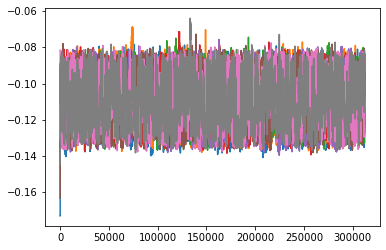

a0


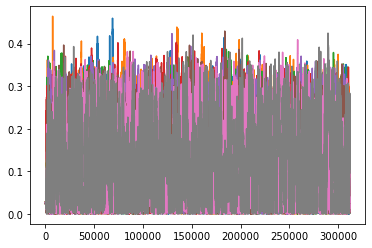

autocorrelation


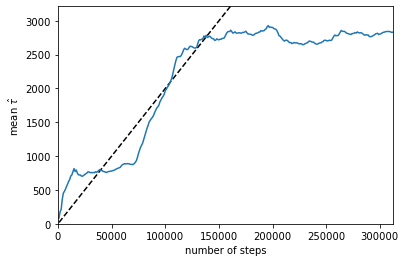

mean acceptance fraction


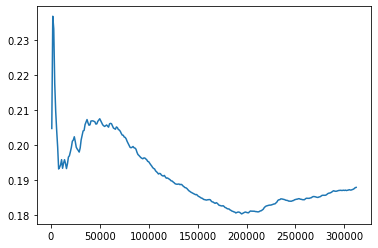

In [24]:
# This box for convergence and time testing together with use_convergence = True

#%timeit make_entry(0)

for j in range(1):
    print(j)
    d,s, a, m= make_entry(j)
    print('mass1')
    for i in range(8):
        plt.plot(s.chain[i,:,0])
    plt.show()
    print('a0, prior value is %.2f' data[j]['a0_prior'])
    for i in range(8):
        plt.plot(s.chain[i,:,3])
    plt.show()
    print('autocorrelation')
    n = 1000 * np.arange(1, len(a) + 1)
    plt.plot(n, n / 50.0, "--k")
    plt.plot(n, a)
    plt.xlim(0, n.max())
    plt.ylim(0, a.max() + 0.1 * (a.max() - a.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$");
    plt.show()
    
    print('mean acceptance fraction')
    plt.plot(n,m)
    plt.show()

burn-in: 6239
thin: 1145
flat chain shape: (2670, 5)
flat log prob shape: (2670,)
flat log prior shape: (2670,)


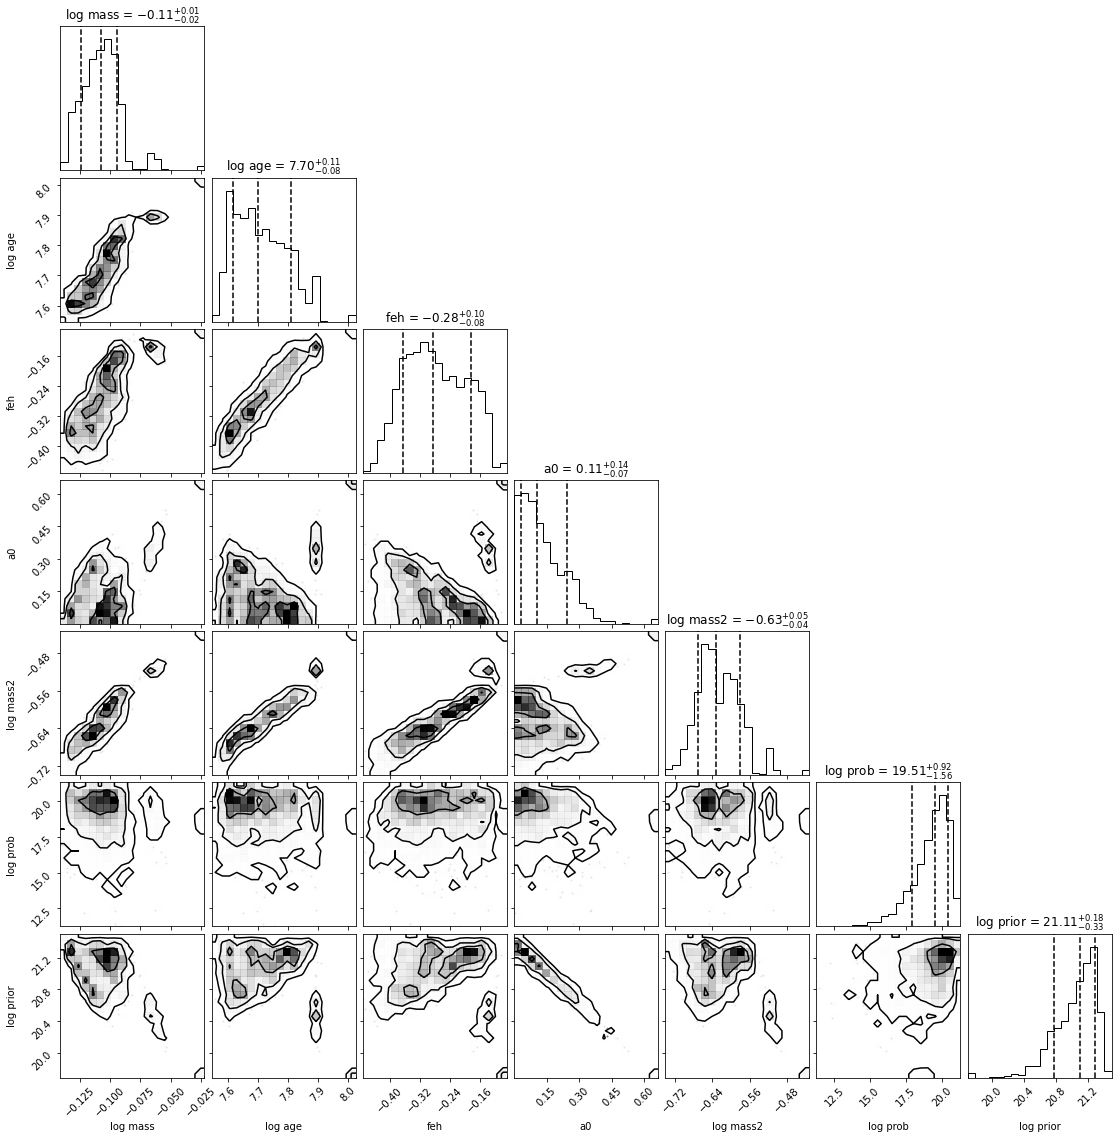

In [32]:
# This box for result plotting together with use_convergence = True

ndim = 5
sampler = s

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)[:,-1]

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)

labels = ["log mass", "log age", "feh", 'a0', 'log mass2']
labels += ["log prob", "log prior"]

corner.corner(all_samples, labels=labels, quantiles = (0.16,0.5,0.84),show_titles=True,
             levels = 1.0 - np.exp(-0.5 * np.arange(1, 4, 1) ** 2));

In [ ]:
# This box for mass production, just run through with shorter chain length and use_convergence = False
# This will likely have higher error on the inferred parameters
break

start = time.time()

pool = Pool(processes = None)
result = pool.map(make_entry, range(len(data)))

end = time.time()
print('took %d seconds' %(int(end-start)))

for j in range(len(data)):
    data[j] = result[j]

In [ ]:
fits.writeto("../data/value_added_binaries.fits",data)